This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course.  We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course.  Even if you have taken the DL class, we will go slower and get into more detail here!

# Transfer Learning for Natural Language Modeling
### Contructing a Language Model and a Sentiment Classifier for IMDB movie reviews

Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).

We will first build a language model for IMDB movie reviews.  Next we will build a sentiment classifier, which will predict whether a review is negative or positive, based on its text. For both of these tasks, we will use **transfer learning**. Starting with the pre-trained weights from the `wikitext-103` language model, we will tune these weights to specialize to the language of `IMDb` movie reviews. 

## Language Models

Language modeling can be a fun creative form. Research scientist [Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text.  For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [3]:
# bs=192
bs=48
# bs=24

### Fix this line: should be `device(0)` instead of `device(2)`

In [4]:
#torch.cuda.set_device(2)
torch.cuda.set_device(0)

## 1. Prepare the IMDb data (on a sample)

First let's download the dataset we are going to study. The `IMDb` [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a `DataBunch` containing this data in one line of code:

### Load and preprocess the data and form a `databunch`
Add workaround for the bug in the `fastai Text API`

In [8]:
## Just to know how the csv looks
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [10]:
df['is_valid'].value_counts()


False    800
True     200
Name: is_valid, dtype: int64

In [9]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        # 👇👇👇👇👇👇👇👇👇👇 main step
        
        data_lm = TextDataBunch.from_csv(path, 'texts.csv')
        
        # 👆👆👆👆👆👆👆👆👆👆
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 421 ms, sys: 376 ms, total: 796 ms
Wall time: 2.71 s


By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a python list called `itos` (for int to string).

In [10]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data_lm.train_ds[0]

(Text [   2    5   98   10 ...   12 1315 2445   11], Category 0)

In [12]:
data_lm.train_ds[0][0]

Text [   2    5   98   10 ...   12 1315 2445   11]

But the underlying data is all numbers

In [13]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,  98,  10,  65,  84,  19, 151,  11,  26])

In [14]:
data_lm.train_ds[0][0].text

'xxbos xxmaj well , what can i say . \n \n  " xxmaj what the xxmaj bleep do we xxmaj know " has achieved the nearly impossible - leaving behind such masterpieces of the genre as " xxmaj the xxmaj postman " , " xxmaj the xxmaj dungeon xxmaj master " , " xxmaj merlin " , and so fourth , it will go down in history as the single worst movie i have ever seen in its entirety . xxmaj and that , ladies and gentlemen , is impressive indeed , for i have seen many a bad movie . \n \n  xxmaj this masterpiece of modern cinema consists of two interwoven parts , xxunk between a silly and contrived plot about an extremely annoying photographer , abandoned by her husband and forced to take anti - xxunk to survive , and a bunch of talking heads going on about how quantum physics supposedly xxunk their new - xxunk pseudo - philosophy . xxmaj basically , if you start your day off xxunk to the likes of xxmaj enya and xxmaj kenny g , this movie is for you . xxmaj if you have a sense of humor , a crowd of pe

### Alternative approach: with the `data block API`

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

### Load and preprocess the data and form a `datablock`
Add workaround for the bug in the `fastai Text API`

In [15]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())        
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 625 ms, sys: 414 ms, total: 1.04 s
Wall time: 2.79 s


## 2. Transfer Learning <br>
### We are going to create an `IMDb` language model starting with the pretrained weights from the `wikitext-103` language model.

Now let's grab the full `IMDb` dataset for what follows.

In [16]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [17]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

**train/pos has 12500 reviews, similarly , test/pos, train/neg, test/neg. Each review is stored in a separate .txt file
unsup has 50000 .txt files, each having one review**


### More about WikiText-103

We will be using the `WikiText-103` dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

*The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.*

*Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.*

[Download wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip). Unzip it into the `.fastai/data/` folder on your computer.

### 2A. Package the `IMDb` data into a language model `databunch`

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (this takes a few minutes).

We'll to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training; we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

Add a `try-except` wrapper as a workaround for the bug in the `fastai Text API`

In [18]:
%%time

# throws `BrokenProcessPool` Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           # notebook 3-logreg-nb-imbd used .split_by_folder instead of .filter_by_folder
            # and this took less time to run. Can we do the same here?
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42))
           #We randomly split and keep 10% (10,000 reviews) for validation
            #.label_for_lm()           
           #We want to make a language model so we label accordingly
            #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 2.42 s, sys: 33.9 ms, total: 2.46 s
Wall time: 2.45 s


#### I got faster results when I do the last two steps in a separate cell:

In [19]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        #     the next step is the bottleneck
        data_lm = (data_lm.label_for_lm()           
           #We want to make a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 22.9 s, sys: 9.52 s, total: 32.4 s
Wall time: 1min 8s


In [20]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(60000, 90000)

In [21]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj weird xxmaj al was funny as usual in the intro , but that was where the laughs ended . xxmaj this movie tries to recapture the humor of xxmaj airplane and xxmaj the xxmaj naked xxmaj gun , but fails miserably . xxmaj it seems clear that the people who put this movie together did not even understand this type of humor . \n \n xxmaj in"
1,"everyone is xxup ok at the end and xxmaj boy stays with xxmaj tarzan and xxmaj jane . \n \n xxmaj as well as xxmaj johnny xxmaj weissmuller as xxmaj tarzan and xxmaj maureen o'sullivan as xxmaj jane , the cast also features xxmaj johnny xxmaj xxunk in his first role as xxmaj boy , xxmaj british actor xxmaj ian xxmaj hunter and xxmaj henry xxmaj stephenson . \n"
2,"the truth is far worse . xxbos xxmaj this is one shoddy piece of work . xxmaj not hateful , because it does n't actively promote antisocial behavior , and not bad enough to be unintentionally amusing either . xxmaj it 's a straightforward attempt to cobble together a cheap movie , while putting no time or effort into it , and drawing in enough patrons to make a profit"
3,"with a xxmaj scottish accent who dies to the sound of xxmaj scottish xxmaj bagpipes . xxmaj alongside him is the tedious xxmaj christopher xxmaj lambert who speaks so softly during the film that the volume needs to be raised to a degree that any sound effect xxunk the audience . xxmaj whilst a novel if unbelievable partnership in the first film , in the sequel xxmaj connery and xxmaj"
4,"performance , but it was xxmaj keaton that got a big start with the film . \n \n xxmaj winkler & xxmaj long were magnificent , and xxmaj keaton was so crazy that you laughed every time he opened his mouth . xxmaj it was a pleasant experience . \n \n xxmaj great soundtrack , too . xxbos xxmaj this first movie "" xxmaj mimic "" already was"


#### Save the `databunch` for next time.

In [35]:
data_lm.save(path/'lm_databunch')

#### Load the saved data

In [36]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

### 2B. The **Transfer Learning** step.
#### This is where the magic happens!
#### The `AWD_LSTM` object contains the pretrained weights and the neural net architecture of the `wikitext-103` language model. These will be downloaded the first time you execute the following line, and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file). 

We import these into the `language_model_learner` object for our `IMDb` language model as follows:

In [38]:
?? AWD_LSTM

In [39]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

#### Get the `IMDb` language model `vocabulary`

In [40]:
vocab = data_lm.vocab

In [41]:
vocab.stoi["stingray"]

36870

In [42]:
vocab.itos[vocab.stoi["stingray"]]

'stingray'

In [43]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [44]:
awd = learn_lm.model[0]

#### Get the `IMDb` language model `encoder`. Recall that the `encoder` translates tokens into numerical vectors in the space defined by the `IMDb` vocabulary.

In [46]:
enc = learn_lm.model[0].encoder

In [47]:
enc.weight.size()

torch.Size([60000, 400])

Since the imdb vocab has 60000 elements, we have the same in enc, and 400 represent the size of each vector. Each vector is of 400 dimension and represent a unique word from vocab.

#### Difference in vocabulary between IMDB and Wikipedia language models

We are going to load `wiki_itos` (the index-to-string list) from the `wikitext 103` language model.  We will compare the vocabularies of `wikitext-103` and `IMDB`.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [48]:
#wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

In [49]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [50]:
len(wiki_itos)

60000

In [51]:
len(vocab.itos)

60000

In [52]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [53]:
wiki_words = set(wiki_itos)

In [54]:
imdb_words = set(vocab.itos)

In [55]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [56]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [57]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [58]:
wiki_not_imdb_list[:15]

['eventing',
 'christgau',
 'nucleotides',
 'squids',
 'sørland',
 'preclearance',
 'prawns',
 'parslow',
 'xiii-2',
 'avm',
 'khl',
 'silversmith',
 'buna',
 '14-yard',
 'chert']

In [59]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [60]:
imdb_not_wiki_list[:15]

['gether',
 'starcade',
 'cahiers',
 'fakey',
 'oooh',
 '7-year',
 'n’t',
 'aloofness',
 "l'homme",
 'queeny',
 'unfashionable',
 'marketeers',
 'buffoonery',
 'luckiest',
 'drac']

All words that appear in the `IMDB` vocab, but not the `wikitext-103` vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn their weights.

In [61]:
vocab.stoi["modernisation"]

0

In [62]:
"modernisation" in wiki_words

True

In [63]:
vocab.stoi["30-something"]

25677

In [64]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [65]:
vocab.stoi["linklater"]

17703

In [66]:
"linklater" in wiki_words, "linklater" in imdb_words

(False, True)

In [67]:
"house" in wiki_words, "house" in imdb_words

(True, True)

In [74]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["linklater"], :].cpu().detach().numpy())

## Shows that since 30-something and linklater are both not present in the wiki_words
## Of which the encoder is based, are mapped to unk and hence have same encoding vector.

True

In [76]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["house"], :].cpu().detach().numpy())

False

In [77]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

#### Generating fake movie review-like text with the **untrained** `IMDb` language model

In [78]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [79]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is being well explained , and the colours are described as being from the sky . In the song " Old Rains " , the giant is described as having a white fur , with the stars facing
The color of the sky is presented by a red flag , which is a blue body in its own right . The red and black green sky is also used , as is the blue , which is the symbol of the Earth


In [80]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [81]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie by Melville Premise , " a Russian Light " , John Legend 's The Power of One : The
I hated this movie ( a musical ) . He wrote : " i wanted to make a movie about a movie . i was just going to help i get through it


In [82]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie = 
 
  " i ' m a Vampire " is a role - playing video game developed and published by Sony Computer Entertainment ( PC
I hated this movie by Danny Elfman , Colin Howard and Philip Glass , Peter Rabbit and Tom Transitioned . This was targeting


In [83]:
doc(LanguageLearner.predict)

Lowering the `temperature` will make the texts less randomized.

In [84]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said , " It 's a bad thing . It 's a bad thing . " The film was
I hated this movie by John Lennon , and he said , " It 's a great thing to do . It 's a great thing to do . "


In [85]:
doc(LanguageLearner.predict)

In [86]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said , " It 's a great film . It 's a great film . It 's a great
I hated this movie by James Bond , and he said , " It 's a bad thing . It 's a bad thing . It 's a bad


### 2C. Training (fine-tuning) the `IMDb` language model
#### Starting with the `wikitext-103` pretrained weights, we'll fine-tune the model to "learn" the structure in the "language" of IMDb movie reviews.

#### Choose an appropriate learning rate.

In [88]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


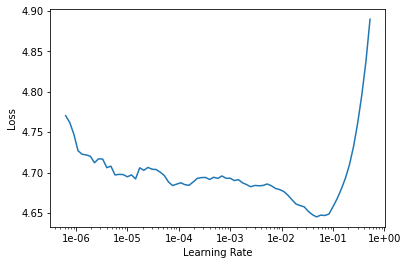

In [89]:
learn_lm.recorder.plot(skip_end=15)

In [93]:
lr = 1e-3
lr *= bs/48

#### Use the mixed-precision option, if you have it, otherwise omit this step

In [94]:
learn_lm.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj this movie really sucks , but still it´s fun to watch . xxmaj for 90 minutes it´s just gunfights and explosions . xxmaj no talking , just shooting . xxmaj it´s amazing to see fully grown men act like this , and being serious about it ! xxmaj if you have nothing to do on a late xxmaj sunday night , then give this one a try !,xxbos xxmaj weird xxmaj al was funny as usual in the intro , but that was where the laughs ended . xxmaj this movie tries to recapture the humor of xxmaj airplane and xxmaj the xxmaj naked xxmaj gun , but fails miserably . xxmaj it seems clear that the people who put this movie together did not even understand this type of humor . 
 
  xxmaj in xxmaj airplane , the humor lies in taking logical steps from peculiar interpretations of events . " xxmaj surely your joking " " i 'm serious , and do n't call me xxmaj shirley . " xxmaj now that 's funny . 
 
  xxmaj this movie , 

#### The first step in fine-tuning is to train only the last layer of the model. 
This takes about a half-hour on an NVIDIA RTX-2070 GPU

In [95]:
# First agrument is for number of epochs
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.198261,3.453823,0.314286,09:29


Since this is relatively slow to train, we will save our weights:

In [96]:
learn_lm.save('fit_1')

In [97]:
learn_lm.load('fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj this movie really sucks , but still it´s fun to watch . xxmaj for 90 minutes it´s just gunfights and explosions . xxmaj no talking , just shooting . xxmaj it´s amazing to see fully grown men act like this , and being serious about it ! xxmaj if you have nothing to do on a late xxmaj sunday night , then give this one a try !,xxbos xxmaj weird xxmaj al was funny as usual in the intro , but that was where the laughs ended . xxmaj this movie tries to recapture the humor of xxmaj airplane and xxmaj the xxmaj naked xxmaj gun , but fails miserably . xxmaj it seems clear that the people who put this movie together did not even understand this type of humor . 
 
  xxmaj in xxmaj airplane , the humor lies in taking logical steps from peculiar interpretations of events . " xxmaj surely your joking " " i 'm serious , and do n't call me xxmaj shirley . " xxmaj now that 's funny . 
 
  xxmaj this movie , 

#### To complete the fine-tuning, we unfreeze all the weights and retrain
Adopting the `wikitext-103` weights as initial values, our neural network will adjust them via optimization, finding new values that are specialized to the "language" of `IMDb` movie reviews.

In [98]:
learn_lm.unfreeze()

Fine tuning the model takes ~30 minutes per epoch on an NVIDIA RTX-2070 GPU, with bs=48<br>
Note the relatively low value of accuracy, which did not improve significantly beyond `epoch 4`.

In [101]:
learn_lm.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.865962,3.245415,0.328571,10:46
1,3.784315,3.027055,0.342857,10:47
2,3.663490,3.052638,0.328571,10:47
3,3.557797,3.027271,0.328571,10:45


#### Save the fine-tuned **language model** and the **encoder**
We have to save not just the `fine-tuned` **IMDb language model** but also its **encoder**. The **language model** is the part that tries to guess the next word. The **encoder** is the part that's responsible for creating and updating the hidden state. 

In the next part we will build a **sentiment classifier** for the IMDb movie reviews. To do this we will need the **encoder** from the **IMDb language model** that we built.

In [102]:
learn_lm.save('fine_tuned')

In [103]:
learn_lm.save_encoder('fine_tuned_enc')

#### Load the saved **model** and its **encoder**

In [104]:
learn_lm.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj this movie really sucks , but still it´s fun to watch . xxmaj for 90 minutes it´s just gunfights and explosions . xxmaj no talking , just shooting . xxmaj it´s amazing to see fully grown men act like this , and being serious about it ! xxmaj if you have nothing to do on a late xxmaj sunday night , then give this one a try !,xxbos xxmaj weird xxmaj al was funny as usual in the intro , but that was where the laughs ended . xxmaj this movie tries to recapture the humor of xxmaj airplane and xxmaj the xxmaj naked xxmaj gun , but fails miserably . xxmaj it seems clear that the people who put this movie together did not even understand this type of humor . 
 
  xxmaj in xxmaj airplane , the humor lies in taking logical steps from peculiar interpretations of events . " xxmaj surely your joking " " i 'm serious , and do n't call me xxmaj shirley . " xxmaj now that 's funny . 
 
  xxmaj this movie , 

Now that we've trained our model, different representations have been learned for the words that were in `IMDb` but not `wikitext-103` (remember that at the beginning we had initialized them all to the same thing):

In [105]:
enc = learn_lm.model[0].encoder

In [108]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["linklater"], :].cpu().detach().numpy())

False

In [111]:
## Showing that their ecoding (vector representing word) has changed 
##(previously these 2 were same)
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), new_word_vec.cpu().detach().numpy())

False

#### Generate movie review-like text, with the **fine-tuned** ` IMDb` language model
Compare these texts to the ones generated with the **untrained** `IMDb model` in part **2A**. Do they seem qualitatively better?

How good is our fine-tuned IMDb language model? Well let's try to see what it predicts when given a phrase that might appear in a movie review.

In [112]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [113]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it had the same style and style as Half Past Dead , but with a different movie . The movie is not about bad guys , but the movie is n't so bad it 's good
i liked this movie because Kevin Bacon is one of my favorite actors . He 's so good and so wonderful in this movie and the movie is a 10 out of 10 . 
 
  The movie is about a man


In [114]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [115]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was so bad i was amazed at how funny it was . An evil man is being chased by a group of bad guys ( with a few exceptions )
This movie was refreshing . It was like a long - standing Hollywood Hollywood - type movie . But this movie was so well written and directed , i


In [116]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [117]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . i did n't like it . i 'm a fan of John Travolta . i hate him as a super human actor . He is a very bad actor . She was a great talent
I hated this movie , because i was a big fan of the original - so i thought it was a good movie , and i had already seen the original version . This movie was the best movie i have ever seen


#### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, *I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.*

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

<img src="images/robot-overflow.png" alt="Roboflow" style="width: 80%"/>

<img src="images/husain-tweet.png" alt="Roboflow" style="width: 60%"/>

## 3. Building an `IMDb Sentiment Classifier`
#### We'll now use **transfer learning** to create a `classifier`, again starting from the pretrained weights of the `wikitext-103` language model.  We'll also need the `IMDb language model` **encoder** that we saved previously. 

### 3A. Load and preprocess the data, and form a `databunch`
Using fastai's flexible API, we will now create a different kind of `databunch` object, one that is suitable for a **classifier** rather than a for **language model** (as we did in **2A**). This time we'll keep the labels for the `IMDb` movie reviews data. 

Add the `try-except` wrapper workaround for the bug in the `fastai Text API`

Here the batch size is decreased from 48 to 8, to avoid a `CUDA out of memory error`; your hardware may be able to handle a larger batch, in which case training will likely be faster.

Again, this takes a bit of time.

In [119]:
# bs=8
bs=48

In [120]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
#    the progress bar has to complete three consecutive steps. Why three? 
#    fails nearly 100 times, and doesn't respond to interrupt
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos']))
             #label them all with their folders
             #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')   
        
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 15.2 s, sys: 19.7 s, total: 34.9 s
Wall time: 3min 21s


#### Form the preprocessed data into a `databunch`

In [121]:
data_clas = data_clas.databunch(bs=bs, num_workers=1)

#### Save the databunch (since it took so long to make) and load it

In [122]:
data_clas.save('imdb_textlist_class')

In [123]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [124]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( xxmaj french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of",pos
"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj",pos
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent yuppie flick about relationships gone bad . i was wrong ; this was an engrossing excursion into the screwed - up libidos of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj ophuls ' "" xxmaj la xxmaj ronde",pos


### 3B. Create a model to **classify** the `IMDb` reviews, and load the **encoder** we saved before.
#### Freeze the weights for all but the last layer and find a good value for the learning rate. 

In [125]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3).to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [126]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


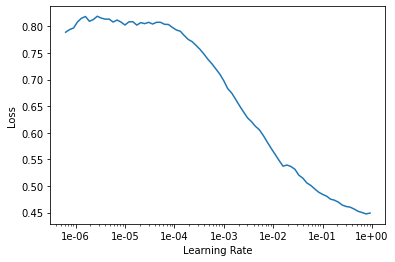

In [127]:
learn_c.recorder.plot()

### 3C. Training and fine-tuning the `IMDb sentiment classifier`

#### Train for one cycle, save intermediate result

In [128]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.245448,0.190685,0.926040,01:28


In [129]:
learn_c.save('first')

In [130]:
learn_c.load('first');

#### Unfreeze last two layers and train for one cycle, save intermediate result.

```slice(1e-2/(2.6**4),1e-2)```  provides a range of lr for starting to end layer, i.e, first layer has the lr ```1e-2/(2.6**4)``` and the last layer will have ```1e-2``` , and the layers in between will have gradually increasing lr from start to end (kinna like range function)

In [131]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.223039,0.168627,0.937000,01:36


In [132]:
learn_c.save('2nd')

#### Unfreeze the last three layers, and train for one cycle, and save intermediate result.
At this point we've already beaten the 2017 (pre-transfer learning) state of the art!

In [133]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.169831,0.145799,0.945680,01:51


In [134]:
learn_c.save('3rd')

In [135]:
learn_c.load('3rd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxup star xxup rating : xxrep 5 * xxmaj saturday xxmaj night xxrep 4 * xxmaj friday xxmaj night * * * xxmaj friday xxmaj morning * * xxmaj sunday xxmaj night * xxmaj monday xxmaj morning 
 
  mcbain ( played by xxmaj gary xxmaj busey , before the name became synonymous with the character in xxmaj the xxmaj simpsons ) is a ( typically ) unorthodox cop who gets results but winds his superiors up something rotten . xxmaj avoiding the cliché of his partner being killed at the beginning of the film , the plot instead takes a different turn and sees him assigned to travel to xxmaj mexico where a top secret xxmaj american super tank with incredible firepower and imaging capabilities has been smuggled through , only to be taken hostage , along with the crew , by a gang of terrorists . 
 
  xxmaj this cheap looking ( even by 80s standards ) , boring little action film was a bizarre career move for xxmaj gary xx

#### Unfreeze all the layers, train for two cycles, and save the result.

Note: at this step I encountered a `CUDA error: unspecified launch failure`. This is a known (and unsolved) problem with PyTorch when using an LSTM. https://github.com/pytorch/pytorch/issues/27837

Nothing to do but try again... and it worked on the second try.

In [136]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.127856,0.152767,0.943240,02:23
1,0.089557,0.164148,0.941640,02:28


The state of the art for this dataset in 2017 was 94.1%, and we have crushed it!!!

#### Save the IMDb classifer model

In [137]:
learn_c.save('clas')

#### Let's look at a few examples, just to check that the classifier is working as we think it should. 
The three outputs of the model predition are the label (`pos` or `neg`) and the class probability estimates for `neg` and `pos`, which meausure the model's confidence in it's prediction. As we'd expect, the model is extremely confident that the first review is `pos` and quite confident that the second review is `neg`. So it passes the test with flying colors. 

In [138]:
learn_c.predict("I really loved that movie, it was awesome!")

(Category tensor(1), tensor(1), tensor([1.4342e-04, 9.9986e-01]))

In [139]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

(Category tensor(0), tensor(0), tensor([9.9942e-01, 5.8042e-04]))

#### Now that we've built the model, here is the part where you get to have some fun!! Take the model for a spin, try out your own examples!!

## Appendix: Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

<img src="images/language_model_zoo.png" alt="language model zoo" style="width: 80%"/>